In [68]:
from functools import partial
from pathlib import Path

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats, optimize, signal
import pandas as pd

In [2]:
# def polynom(x_data: float | npt.NDArray, *args):
#     return sum(a*x_data**n for n, a in enumerate(args))

def no_intercept(x_data, a):
    return a*x_data


def linear(x_data, a, b):
    return a*x_data + b


def r_squared(func, *args, x_data, y_data, **kwargs):
    func = partial(func, *args, **kwargs)
    ss_res = np.sum(np.square(y_data - func(x_data)))
    ss_tot = np.sum(np.square(y_data - np.average(y_data)))
    return 1 - ss_res / ss_tot


def interpolate(df):
    x = np.arange(0, 50, 0.01)
    y = np.interp(x, df['m/z'], df['intensity'])
    return pd.DataFrame({'m/z': x, 'intensity': y})


In [3]:
RESULTS = Path('results')
RESULTS.mkdir(exist_ok=True)

# loading data

In [4]:
all_measures = pd.read_parquet('data/all_measures.parquet')
print(all_measures.info())
all_measures.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29105 entries, 0 to 29104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   m/z          29105 non-null  float64
 1   intensity    29105 non-null  float64
 2   sensitivity  29105 non-null  int64  
 3   sem          29105 non-null  float64
 4   measure      29105 non-null  object 
 5   probe        29105 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 1.3+ MB
None


,m/z,intensity,sensitivity,sem,measure,probe
0,0.072244,1.24143,9,2.8,restgas,previous
1,0.091752,1.24338,9,2.8,restgas,previous
2,0.065741,1.23070,9,2.8,restgas,previous
3,0.078746,1.24566,9,2.8,restgas,previous
4,0.085249,1.23103,9,2.8,restgas,previous


In [5]:
transmission = pd.read_parquet('data/transmission.parquet')
print(transmission.info())
transmission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   m/z          5197 non-null   float64
 1   intensity    5197 non-null   float64
 2   sensitivity  5197 non-null   int64  
 3   sem          5197 non-null   float64
 4   resolution   5197 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 203.1+ KB
None


,m/z,intensity,sensitivity,sem,resolution
0,0.065741,0.573588,8,2.8,low
1,0.065741,0.572612,8,2.8,low
2,0.072244,0.573588,8,2.8,low
3,0.078746,0.573262,8,2.8,low
4,0.072244,0.573262,8,2.8,low


In [6]:
calibration = pd.read_parquet('data/calibration.parquet')
calibration.time = calibration.time.dt.total_seconds()
print(calibration.info())
calibration.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   time         1951 non-null   float64        
 1   pressure     1951 non-null   float64        
 2   intensity    1951 non-null   float64        
 3   time_2       1951 non-null   timedelta64[ns]
 4   intensity_2  1951 non-null   float64        
dtypes: float64(4), timedelta64[ns](1)
memory usage: 76.3 KB
None


,time,pressure,intensity,time_2,intensity_2
0,2.15400,2.063539,0.643489,0 days 00:00:02.653980,0.644377
1,3.15402,2.063539,0.638651,0 days 00:00:03.654000,0.637803
2,4.15398,2.063539,0.647639,0 days 00:00:04.654020,0.641524
3,5.15400,2.063539,0.641842,0 days 00:00:05.653020,0.637501
4,6.15300,2.052205,0.647608,0 days 00:00:06.654000,0.639954


# analysis

## interpolate

In [7]:
all_interpolated = (
    all_measures
    .groupby(['sensitivity', 'measure', 'probe'])
    .apply(interpolate)
    .reset_index()
    .drop('level_3', axis=1)
)
all_interpolated.head()

,sensitivity,measure,probe,m/z,intensity
0,8,all,luft,0.00,1.047
1,8,all,luft,0.01,1.047
2,8,all,luft,0.02,1.047
3,8,all,luft,0.03,1.047
4,8,all,luft,0.04,1.047


In [8]:
transmission_interpolated = (
    transmission
    .groupby(['sensitivity', 'resolution'])
    .apply(interpolate)
    .reset_index()
    .drop('level_2', axis=1)
)
transmission_interpolated.head()

,sensitivity,resolution,m/z,intensity
0,8,high,0.00,0.545625
1,8,high,0.01,0.545625
2,8,high,0.02,0.545625
3,8,high,0.03,0.545625
4,8,high,0.04,0.545625


Text(0, 0.5, 'Intensity')

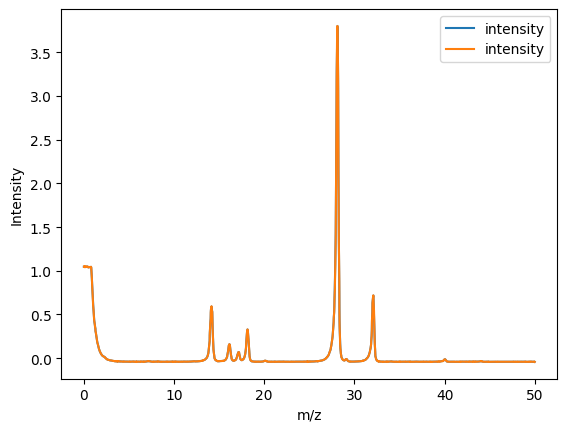

In [9]:
fig, ax = plt.subplots()

for df in (all_interpolated, all_measures):
    df.query('probe == "luft" & measure == "all" & sensitivity == 8').plot(x='m/z', y='intensity', ax=ax)
    
ax.set_ylabel('Intensity')

## subtract

In [10]:
all_interpolated.probe.unique()

array(['luft', 'mixture', 'transmission', 'co2', 'ln2', 'previous'],
      dtype=object)

In [11]:
all_corrected = all_interpolated.pivot(
    index=['probe', 'sensitivity', 'm/z'], 
    columns='measure',
    values='intensity',
)
all_corrected['corrected'] = all_corrected['all'] - all_corrected['restgas']
all_corrected.head()

measure                     all   restgas  corrected
probe sensitivity m/z                               
co2   9           0.00  4.63885  0.629187   4.009663
                  0.01  4.63885  0.629187   4.009663
                  0.02  4.63885  0.629187   4.009663
                  0.03  4.63885  0.629187   4.009663
                  0.04  4.63885  0.629187   4.009663

In [12]:
all_corrected.loc[('transmission', 8), 'restgas']

m/z
0.00     0.028323
0.01     0.028323
0.02     0.028323
0.03     0.028323
0.04     0.028323
           ...   
49.95   -0.041678
49.96   -0.041279
49.97   -0.040932
49.98   -0.040932
49.99   -0.040932
Name: restgas, Length: 5000, dtype: float64

In [13]:
# TODO: this is probably false!!

transmission_corrected = transmission_interpolated.set_index(['sensitivity', 'resolution', 'm/z'])
transmission_corrected['corrected'] = transmission_corrected['intensity'] - all_corrected.loc[('transmission', 8), 'restgas']
transmission_corrected.head()

# This is how it probably how it should be done! Not at all

transmission_corrected = transmission_interpolated.set_index(['sensitivity', 'resolution', 'm/z'])

In [14]:
all_corrected.groupby(['probe', 'sensitivity']).get_group(('co2', 9))

measure                       all   restgas  corrected
probe sensitivity m/z                                 
co2   9           0.00   4.638850  0.629187   4.009663
                  0.01   4.638850  0.629187   4.009663
                  0.02   4.638850  0.629187   4.009663
                  0.03   4.638850  0.629187   4.009663
                  0.04   4.638850  0.629187   4.009663
...                           ...       ...        ...
                  49.95 -0.009394 -0.010369   0.000975
                  49.96 -0.009394 -0.010369   0.000975
                  49.97 -0.009394 -0.010369   0.000975
                  49.98 -0.009394 -0.010369   0.000975
                  49.99 -0.009394 -0.010369   0.000975

[5000 rows x 3 columns]

# Qualitative spectra

In [15]:
corrected_groups = all_corrected.groupby(['probe', 'sensitivity'])

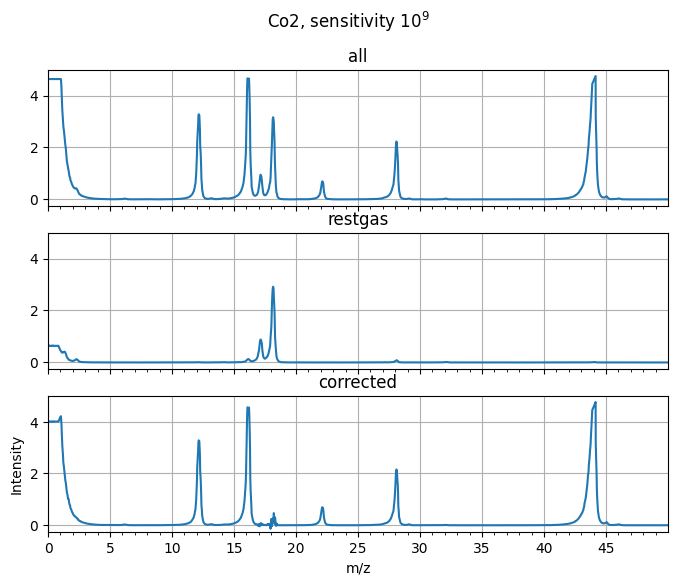

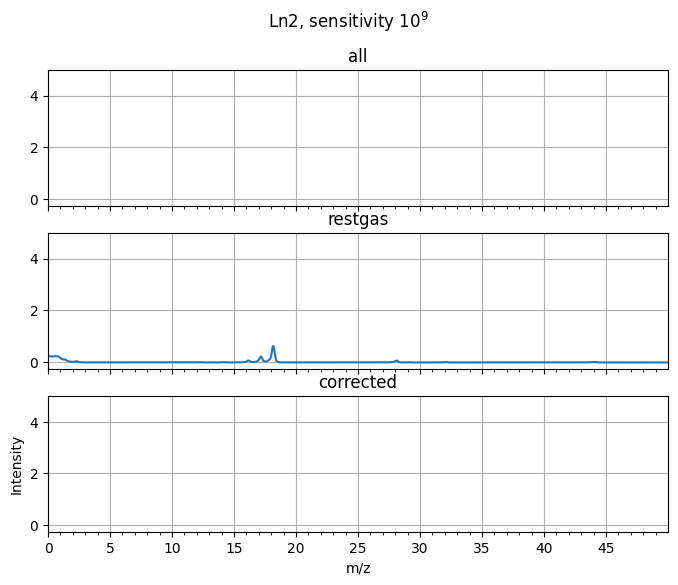

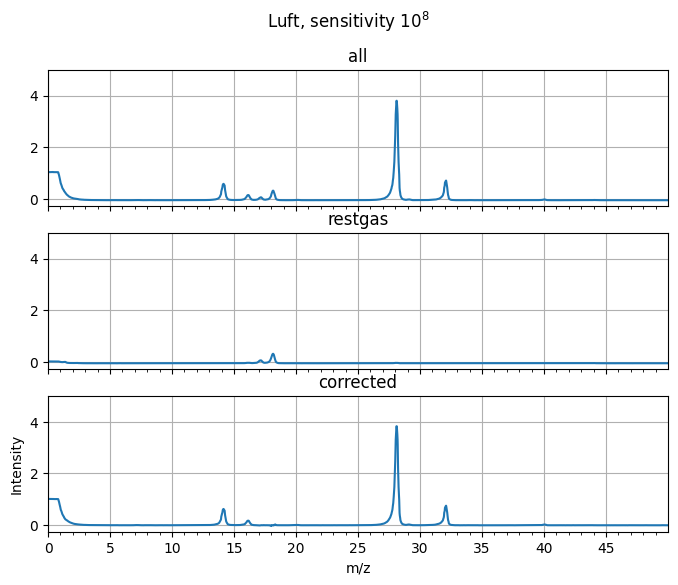

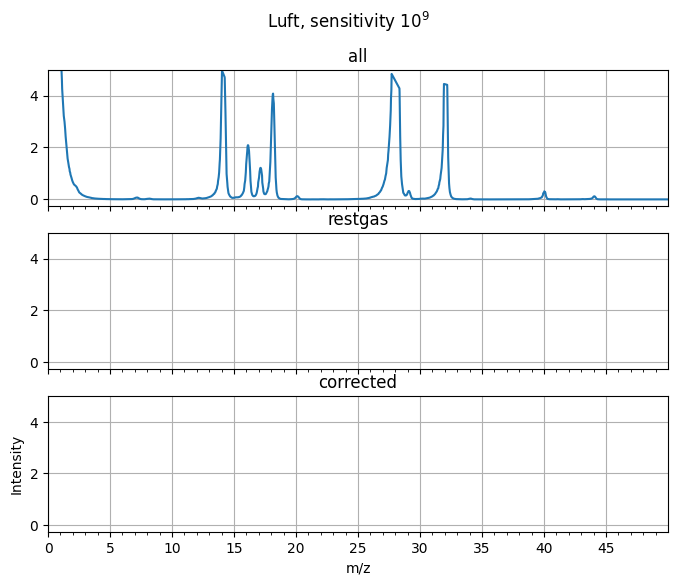

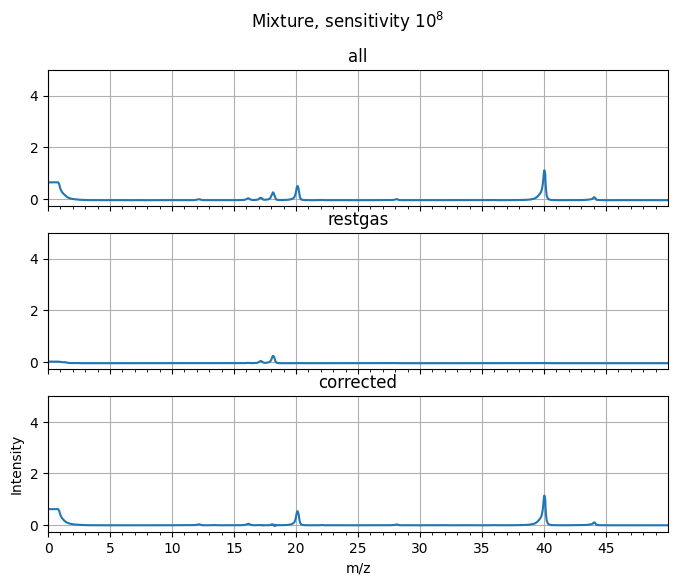

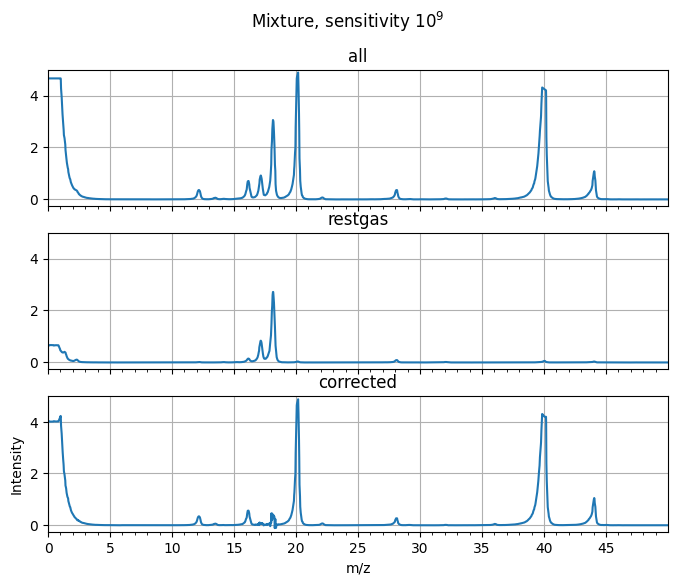

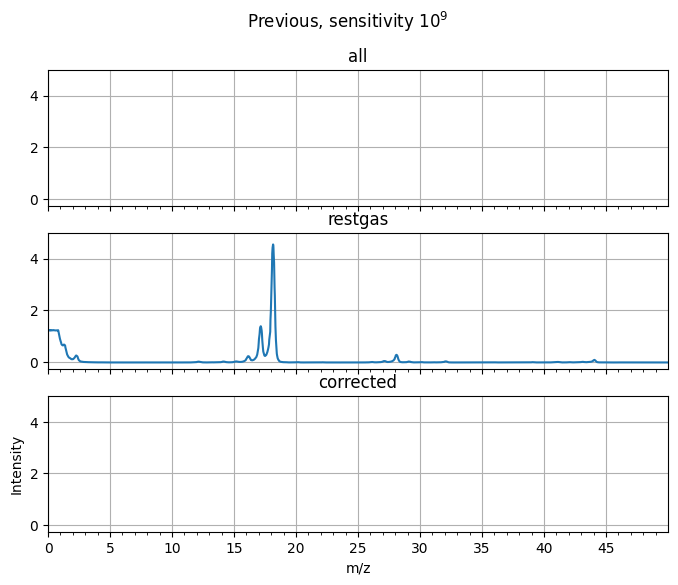

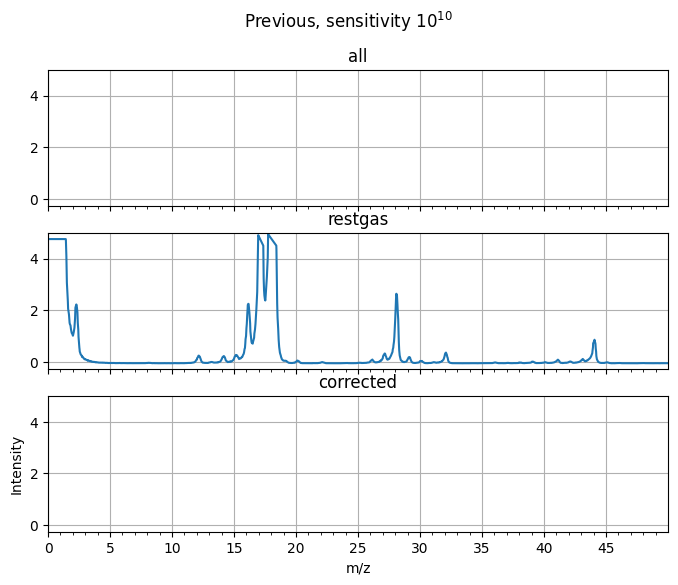

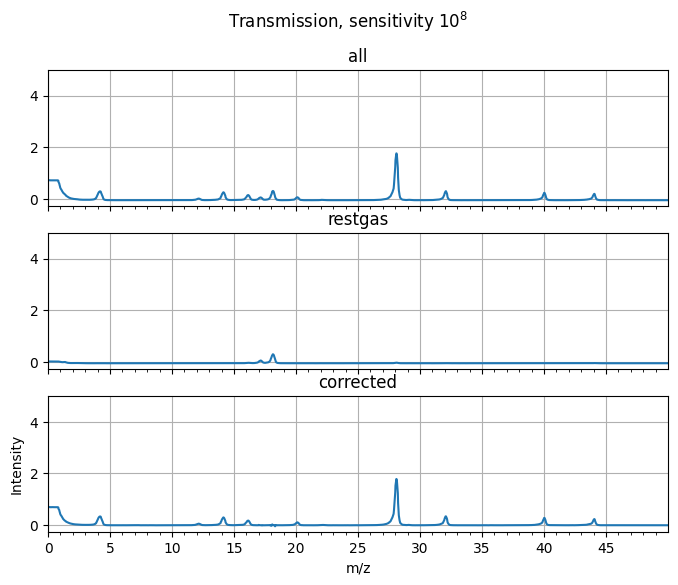

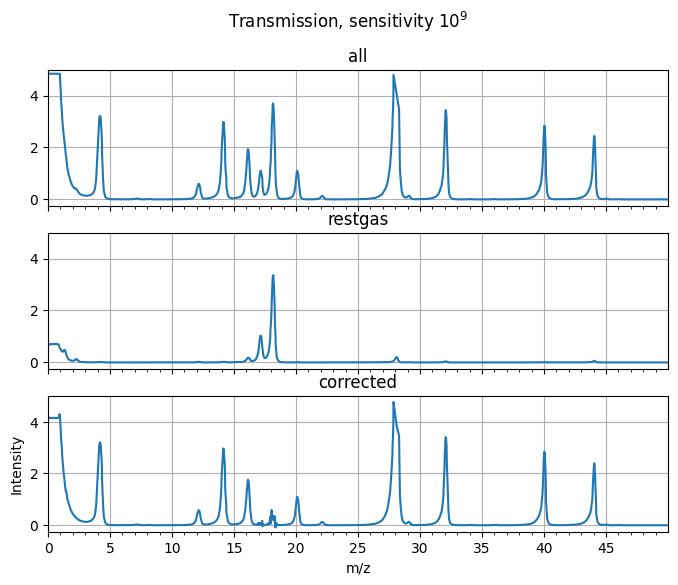

In [16]:
for (name, sensitivity), group in corrected_groups:
    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(name.capitalize()+r', sensitivity $10^{' + str(sensitivity) +'}$')
    for col, ax in zip(group, axs):
        ax.set_title(col)
        _group = group.reset_index(-1)
        ax.plot(_group['m/z'], _group[col])
        
        ax.set_xticks(np.arange(0, 50), minor=True)
        ax.set_xticks(np.arange(0, 50, 5), minor=False)
        ax.grid()
        
    ax.set_xlim(0, 50)
    ax.set_ylim(-0.25, 5)
    
    ax.set_xlabel('m/z')
    ax.set_ylabel('Intensity')
    


In [17]:
group.columns

Index(['all', 'restgas', 'corrected'], dtype='object', name='measure')

In [18]:
def rename_cols(df: pd.DataFrame) -> pd.DataFrame:
    subplot_names = {'all': 'Rohmessung', 'restgas': 'Restgas', 'corrected': 'Korrigierte Messung'}
    return df.rename(subplot_names, axis=1)

def qualitative_spectra(title: str, group: pd.DataFrame, peaks: list[float|int]):
    n_groups = len(group.columns)
    y_size = 2 * n_groups
    fig, axs = plt.subplots(n_groups, 1, figsize=(8, y_size), sharex=True, sharey=True, constrained_layout=True)
    fig.suptitle(title)

    if n_groups == 1:
        axs = [axs]
        
    for col, ax in zip(group, axs):
        ax.text(x=0.04, y=.85, s=col, transform=ax.transAxes, fontsize='medium',
                bbox=dict(boxstyle='round', pad=0.3, mutation_scale=1.5, facecolor='gainsboro', alpha=1, edgecolor='tab:grey')
               )
        _group = group.reset_index(-1)
        ax.plot(_group['m/z'], _group[col])

        ax.set_xticks(np.arange(0, 50), minor=True)
        ax.set_xticks(np.arange(0, 50, 5), minor=False)

        for peak in peaks:
            ax.axvline(peak, color='tab:grey', zorder=0, linewidth=0.5)

    ax.set_xlim(0, 50)
    ax.set_ylim(-0.25, 5)

    fig.supylabel('Intensität')
    fig.supxlabel('m/z')
    return fig, axs

In [19]:
peaks = {
    'co2': [12, 16, 22, 28, 44],
    'ln2': [16, 17, 18, 28],
    'luft': [14, 16, 28, 32, 40],
    'luft_hq': [14, 16, 20, 28, 29, 32, 40, 44],
    'mixture': [12, 16, 20, 28, 40, 44], 
    'transmission': [4, 12, 14, 16, 20, 28, 32, 40, 44],
}

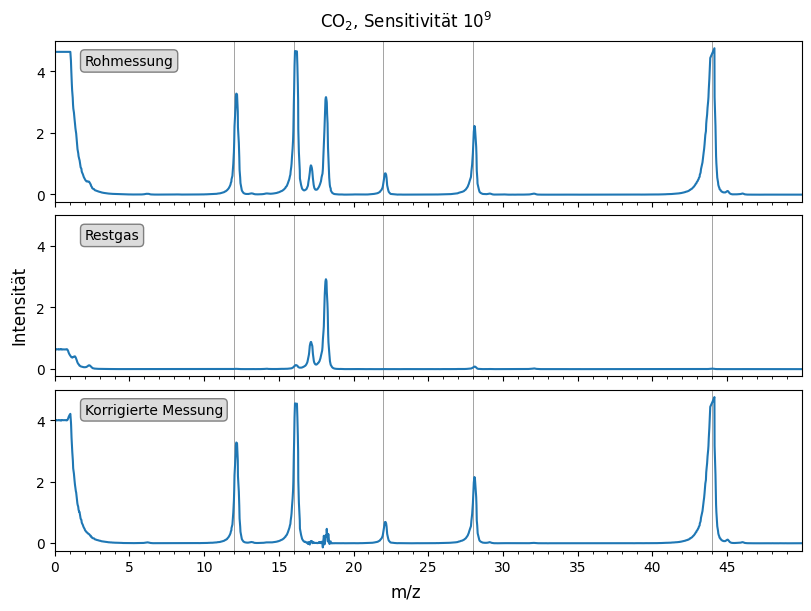

In [20]:
fig, ax = qualitative_spectra(
    title=r'CO$_2$, Sensitivität $10^9$',
    group=corrected_groups.get_group(('co2', 9)).pipe(rename_cols),
    peaks=peaks['co2'],
)
fig.savefig(RESULTS/'co2_9.png', dpi=500, bbox_inches='tight')

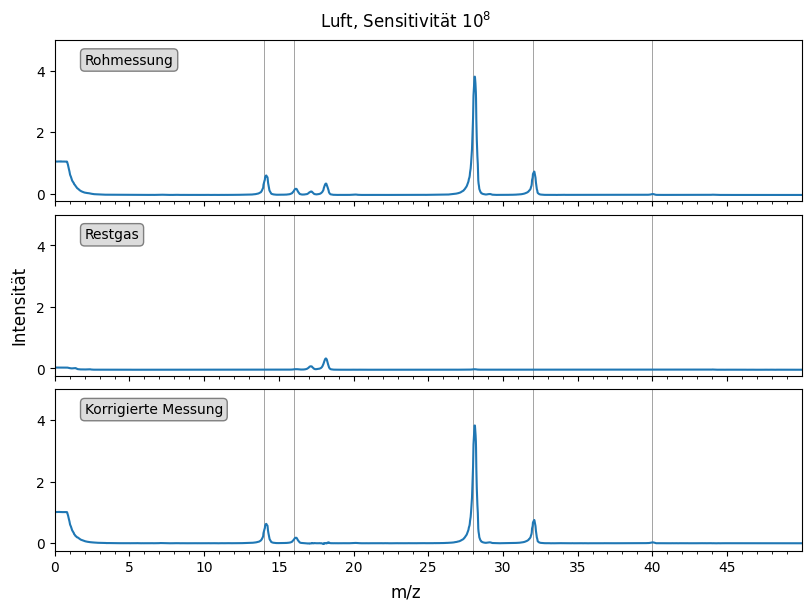

In [21]:
fig, ax = qualitative_spectra(
    title=r'Luft, Sensitivität $10^8$',
    group=corrected_groups.get_group(('luft', 8)).pipe(rename_cols),
    peaks=peaks['luft'],
)
fig.savefig(RESULTS/'luft_8.png', dpi=500, bbox_inches='tight')

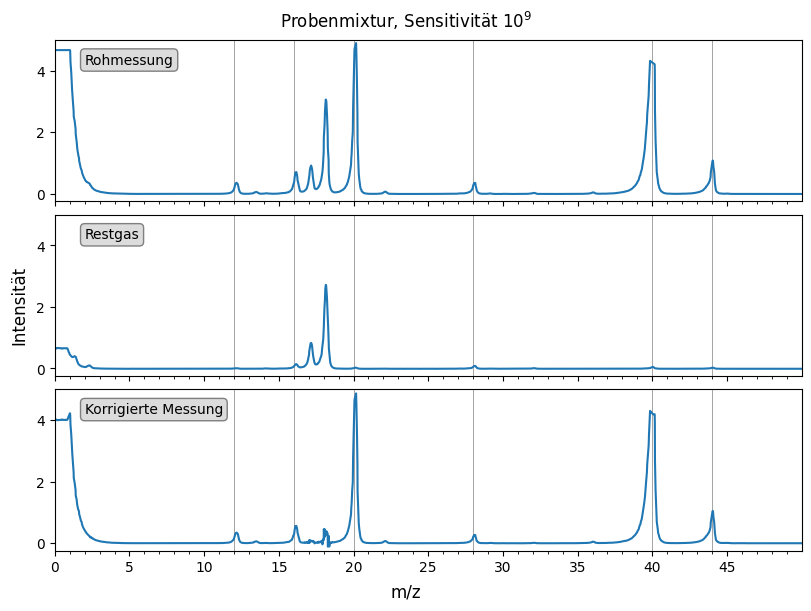

In [22]:
fig, ax = qualitative_spectra(
    title=r'Probenmixtur, Sensitivität $10^9$',
    group=corrected_groups.get_group(('mixture', 9)).pipe(rename_cols),
    peaks=peaks['mixture'],
)
fig.savefig(RESULTS/'probe_9.png', dpi=500, bbox_inches='tight')

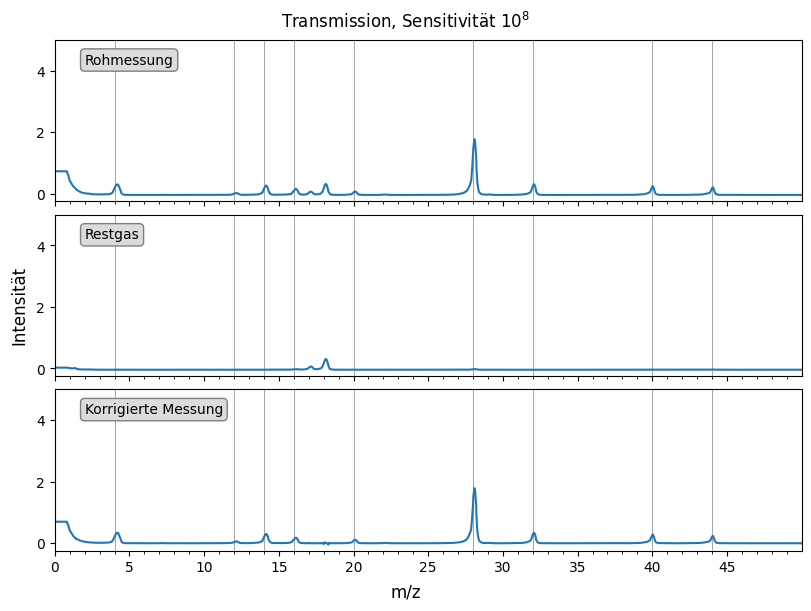

In [23]:
fig, ax = qualitative_spectra(
    title=r'Transmission, Sensitivität $10^8$',
    group=corrected_groups.get_group(('transmission', 8)).pipe(rename_cols),
    peaks=peaks['transmission'],
)
fig.savefig(RESULTS/'transmission_8.png', dpi=500, bbox_inches='tight')

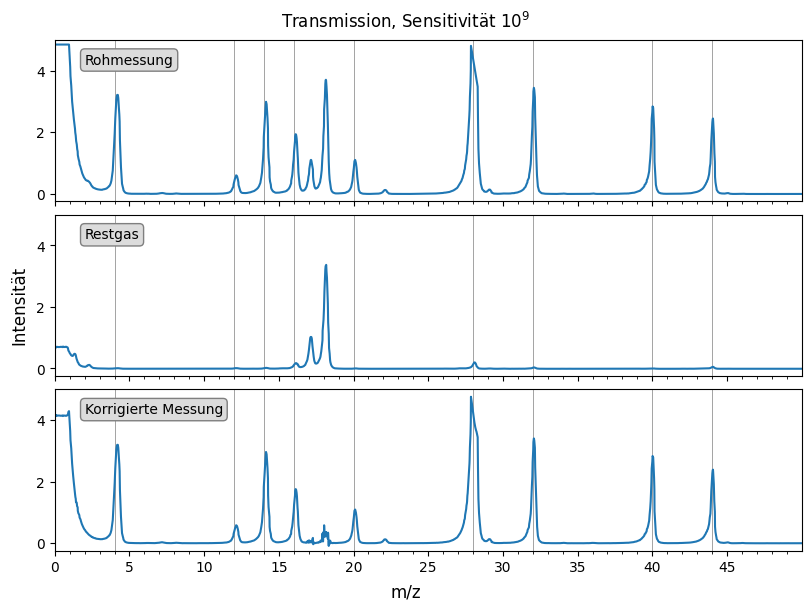

In [24]:
fig, ax = qualitative_spectra(
    title=r'Transmission, Sensitivität $10^9$',
    group=corrected_groups.get_group(('transmission', 9)).pipe(rename_cols),
    peaks=peaks['transmission'],
)
fig.savefig(RESULTS/'transmission_9.png', dpi=500, bbox_inches='tight')

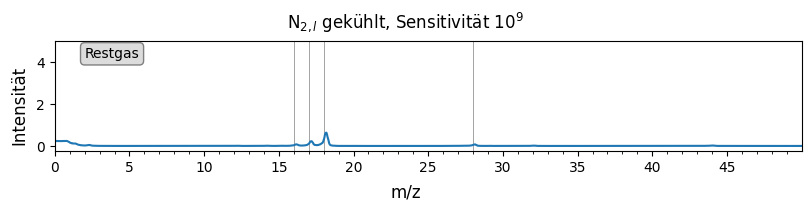

In [25]:
fig, ax = qualitative_spectra(
    title=r'N$_{2, l}$ gekühlt, Sensitivität $10^9$',
    group=corrected_groups.get_group(('ln2', 9)).dropna(axis=1).pipe(rename_cols),
    peaks=peaks['ln2'],
)
fig.savefig(RESULTS/'ln2_9.png', dpi=500, bbox_inches='tight')

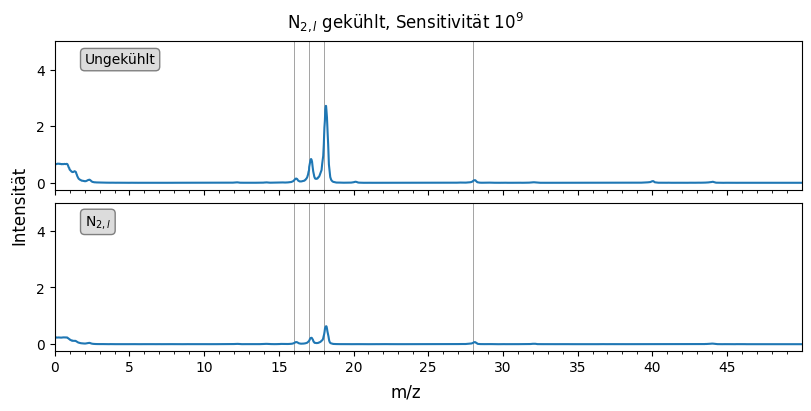

In [26]:
fig, ax = qualitative_spectra(
    title=r'N$_{2, l}$ gekühlt, Sensitivität $10^9$',
    group=corrected_groups.get_group(('mixture', 9)).rename({'restgas': 'Ungekühlt'}, axis=1).get('Ungekühlt').droplevel(0).to_frame().join(
        corrected_groups.get_group(('ln2', 9)).dropna(axis=1).rename({'restgas': 'N$_{2, l}$'}, axis=1).droplevel(0)
    ),
    peaks=peaks['ln2'],
)
fig.savefig(RESULTS/'restgas_9.png', dpi=500, bbox_inches='tight')

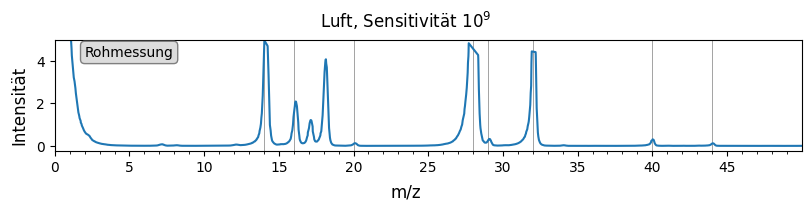

In [27]:
fig, ax = qualitative_spectra(
    title=r'Luft, Sensitivität $10^9$',
    group=corrected_groups.get_group(('luft', 9)).pipe(rename_cols).dropna(axis=1),
    peaks=peaks['luft_hq'],
)
fig.savefig(RESULTS/'luft_9.png', dpi=500, bbox_inches='tight')

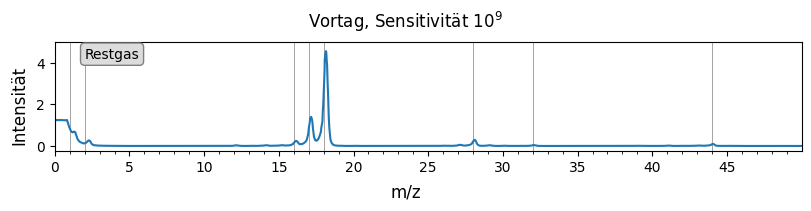

In [28]:
fig, ax = qualitative_spectra(
    title=r'Vortag, Sensitivität $10^9$',
    group=corrected_groups.get_group(('previous', 9)).pipe(rename_cols).dropna(axis=1),
    peaks=[1, 2, 16, 17, 18, 28, 32, 44],
)
fig.savefig(RESULTS/'previous_9.png', dpi=500, bbox_inches='tight')

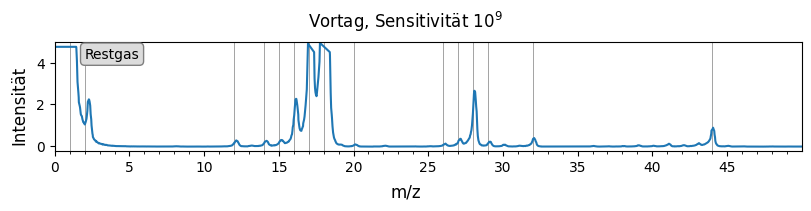

In [29]:
fig, ax = qualitative_spectra(
    title=r'Vortag, Sensitivität $10^9$',
    group=corrected_groups.get_group(('previous', 10)).pipe(rename_cols).dropna(axis=1),
    peaks=[1, 2, 12, 14, 15, 16, 17, 18, 20, 26, 27, 28, 29, 32, 44],
)
fig.savefig(RESULTS/'previous_10.png', dpi=500, bbox_inches='tight')

# Transmission spectra


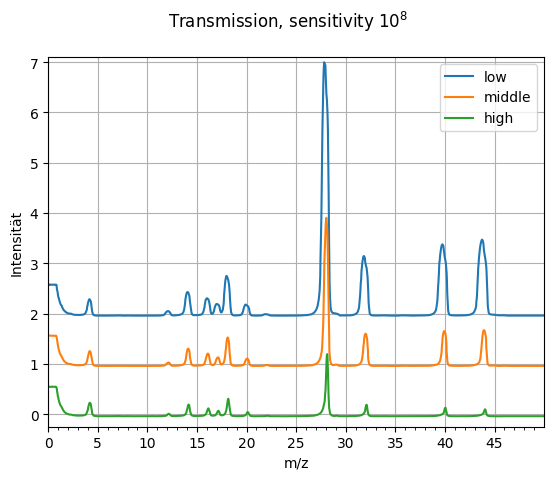

In [70]:
fig, ax = plt.subplots()
fig.suptitle('Transmission, sensitivity $10^{8}$')

for n, resolution in enumerate(('low', 'middle', 'high')):
    group = transmission_corrected.loc[8, resolution].reset_index()
    ax.plot(group['m/z'], group['intensity']+(2-n), label=resolution)

    ax.set_xticks(np.arange(0, 50), minor=True)
    ax.set_xticks(np.arange(0, 50, 5), minor=False)
    ax.grid()

ax.set_xlim(0, 50)
ax.set_ylim(-0.25, 7.1)
ax.legend()

ax.set_xlabel('m/z')
ax.set_ylabel('Intensität')
fig.savefig(RESULTS/'transmission_spectra.png', dpi=500, bbox_inches='tight')

Text(0.5, 1.0, 'Chosen peaks')

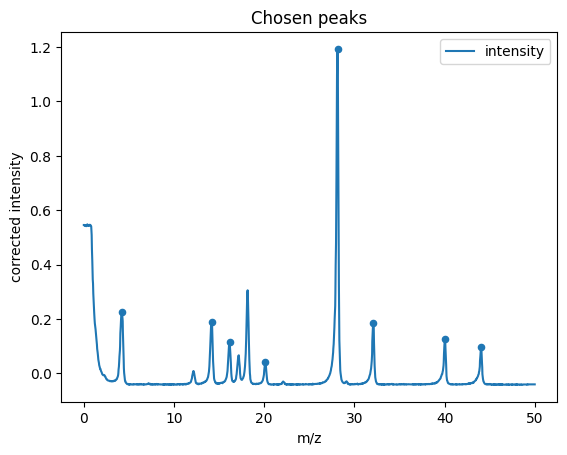

In [31]:
peaks, _ = signal.find_peaks(transmission_corrected.loc[(8, 'high'), 'intensity'], 
                             height=0, prominence=0.05,
                 )
peaks = transmission_corrected.loc[(8, 'low')].iloc[peaks].index
peaks = peaks[(peaks.values < 16.5) | (peaks.values > 18.5)]
fig, ax = plt.subplots()
transmission_corrected.loc[(8, 'high', peaks)].reset_index().plot.scatter(x='m/z', y='intensity', ax=ax)
transmission_corrected.loc[(8, 'high')].reset_index().plot(x='m/z', y='intensity', ax=ax)

plt.ylabel('corrected intensity')
plt.title('Chosen peaks')

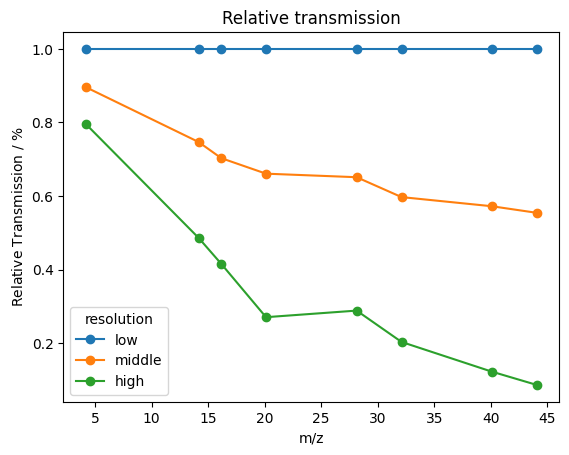

In [71]:
transmission_fit = (transmission_corrected
 .loc[:, :, peaks]
 .droplevel(-3)
 .reset_index()
 .pivot(index='m/z', columns='resolution', values='intensity')
)[['low', 'middle', 'high']]

transmission_fit = transmission_fit.div(transmission_fit.low, axis=0)
transmission_fit.plot(style='-o')
transmission_fit

plt.ylabel('Relative Transmission / $\%$')
plt.title('Relative transmission')

fig.savefig(RESULTS/'transmission_relative.png', dpi=500, bbox_inches='tight')

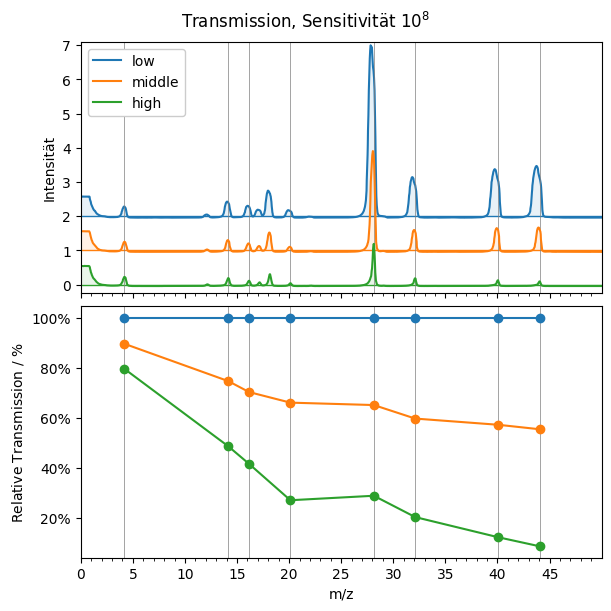

In [33]:
fig, (ax_spectra, ax_rel) = plt.subplots(nrows=2, figsize=(6, 6), sharex=True, constrained_layout=True)
fig.suptitle('Transmission, Sensitivität $10^{8}$')


for n, resolution in enumerate(('low', 'middle', 'high')):
    group = transmission_corrected.loc[8, resolution].reset_index()
    ax_spectra.plot(group['m/z'], group['intensity']+(2-n), label=resolution, zorder=n)
    ax_spectra.fill_between(x=group['m/z'], y1=group['intensity']+(2-n), y2=(2-n), alpha=0.1, zorder=n)
    ax_spectra.axhline(y=2-n, linewidth=1, zorder=0, color=plt.cm.tab10(n))

ax_spectra.set_xticks(np.arange(0, 50), minor=True)
ax_spectra.set_xticks(np.arange(0, 50, 5), minor=False)
ax_spectra.set_xlim(0, 50)
ax_spectra.set_ylim(-0.25, 7.1)
ax_spectra.legend(facecolor='white', framealpha=1)

ax_spectra.set_xlabel('m/z')
ax_spectra.set_ylabel('Intensität')

(transmission_fit * 100).plot(style='-o', ax=ax_rel, legend=False)
ax_rel.yaxis.set_major_formatter(mticker.PercentFormatter())
# ax_rel.axhline(color='k', linewidth=0.5, zorder=0)

ax_rel.set_ylabel('Relative Transmission / $\%$')

for ax in (ax_spectra, ax_rel):
    for peak in peaks:
        ax.axvline(peak, color='tab:grey', zorder=0, linewidth=0.5)
        

fig.savefig(RESULTS/'transmission_resolution.png', dpi=500, bbox_inches='tight')

In [88]:
for_kemal = transmission_corrected.unstack(level=1)
for_kemal = for_kemal.droplevel(0, axis=0).droplevel(0, axis=1)
for_kemal['p_low'] = 100
for_kemal['p_mid'] = for_kemal['middle'] / for_kemal['low'] * 100
for_kemal['p_high'] = for_kemal['high'] / for_kemal['low'] * 100
for_kemal = for_kemal.loc[peaks, 'low p_low middle p_mid high p_high'.split()]
for_kemal.columns = ['$I_{low}$', 'transmission_${low}$ / %', '$I_{middle}$', 'transmission_${middle}$ / %', '$I_{high}$', 'transmission_${high}$ / %']
for_kemal

,$I_{low}$,transmission_${low}$ / %,$I_{middle}$,transmission_${middle}$ / %,$I_{high}$,transmission_${high}$ / %
m/z,,,,,,
4.19,0.283199,100,0.253755,89.602963,0.225360,79.576602
14.16,0.392039,100,0.292794,74.684847,0.190591,48.615168
16.16,0.275436,100,0.193623,70.296976,0.114468,41.558860
20.12,0.150395,100,0.099375,66.076127,0.040678,27.047775
28.13,4.137510,100,2.693992,65.111441,1.193180,28.838130
32.10,0.914037,100,0.545719,59.704257,0.185640,20.309867
40.06,1.039732,100,0.595002,57.226483,0.127409,12.253999
44.05,1.114839,100,0.617976,55.431884,0.096168,8.626194


In [98]:
print((
    for_kemal
    .reset_index()
    .to_latex(
        float_format='%#.4g',
        index=False
    )
)
)

\begin{tabular}{rrrrrrr}
\toprule
m/z & $I_{low}$ & transmission_${low}$ / % & $I_{middle}$ & transmission_${middle}$ / % & $I_{high}$ & transmission_${high}$ / % \\
\midrule
4.190 & 0.2832 & 100 & 0.2538 & 89.60 & 0.2254 & 79.58 \\
14.16 & 0.3920 & 100 & 0.2928 & 74.68 & 0.1906 & 48.62 \\
16.16 & 0.2754 & 100 & 0.1936 & 70.30 & 0.1145 & 41.56 \\
20.12 & 0.1504 & 100 & 0.09938 & 66.08 & 0.04068 & 27.05 \\
28.13 & 4.138 & 100 & 2.694 & 65.11 & 1.193 & 28.84 \\
32.10 & 0.9140 & 100 & 0.5457 & 59.70 & 0.1856 & 20.31 \\
40.06 & 1.040 & 100 & 0.5950 & 57.23 & 0.1274 & 12.25 \\
44.05 & 1.115 & 100 & 0.6180 & 55.43 & 0.09617 & 8.626 \\
\bottomrule
\end{tabular}



# kalibrierung

In [34]:
IW_CO2 = 1.4
IW_AR = 1.2

calibration['pressure'] = calibration['pressure'] / IW_CO2

Text(0.5, 0, 'time $t$')

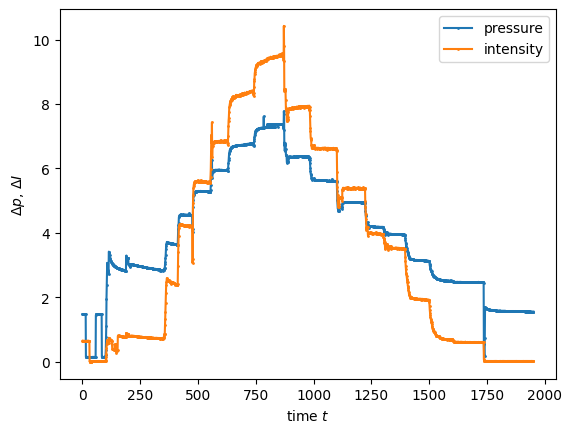

In [35]:
calibration.plot(y=['pressure', 'intensity'], style='o-', ms=1)

calibration['window'] = None


plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

## measures
### leer

Text(0.5, 0, 'time $t$')

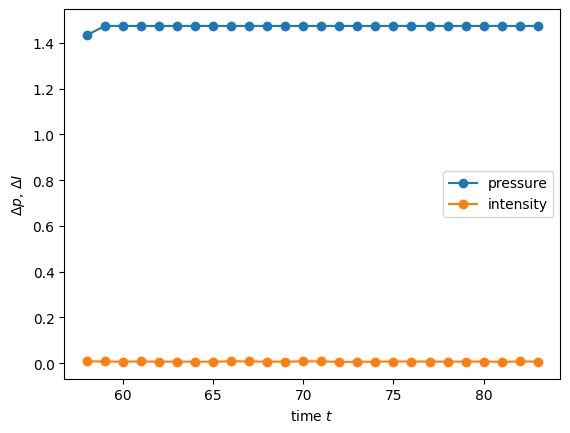

In [36]:
# start # 31:100
calibration.loc[58:83].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[58:83, 'window'] = 'leer'


plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

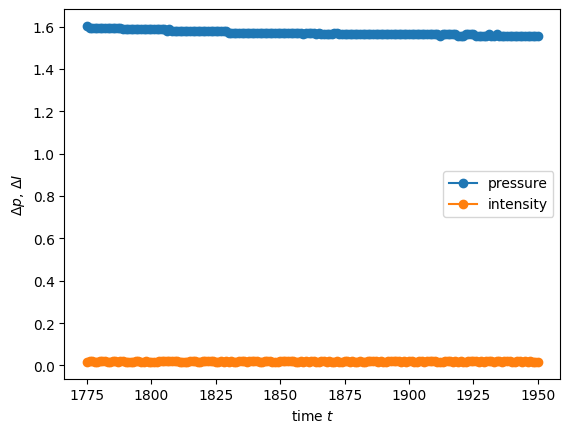

In [37]:
# end
calibration.loc[1775:].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[1775:, 'window'] = 'leer'

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

### probe

Text(0.5, 0, 'time $t$')

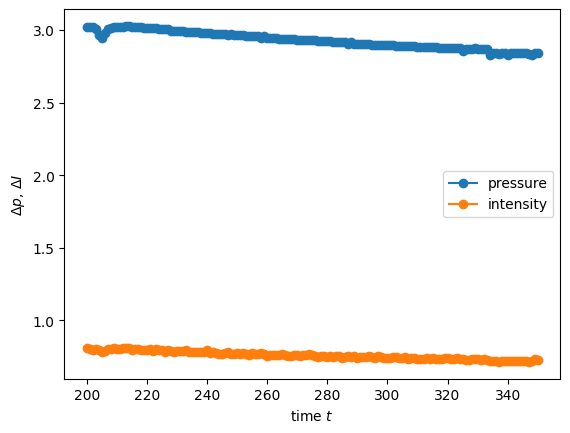

In [38]:
# start
calibration.loc[200:350].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[200:350, 'window'] = 'probe'


plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

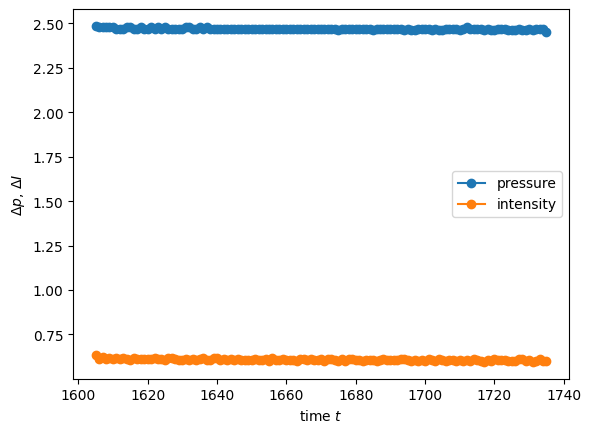

In [39]:
# end
calibration.loc[1605:1735].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[1605:1735, 'window'] = 'probe'


plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

### zugaben

Text(0.5, 0, 'time $t$')

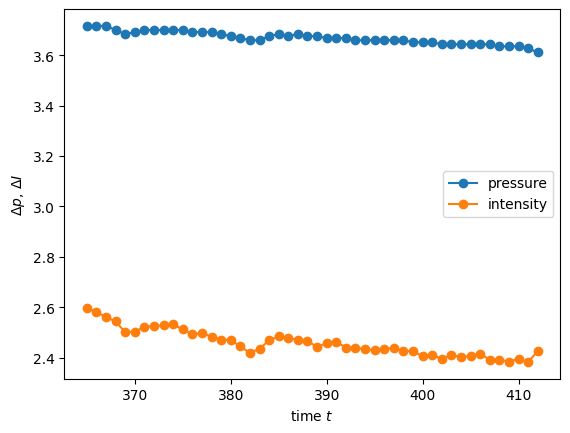

In [40]:
# 1
calibration.loc[365:412].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[365:412, 'window'] = 1


plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

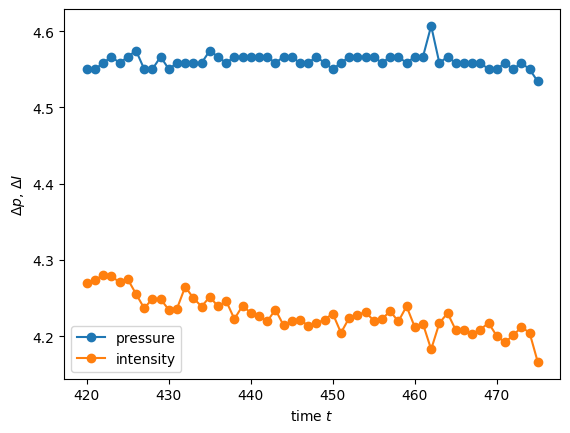

In [41]:
# 2
calibration.loc[420:475].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[420:475, 'window'] = 2

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

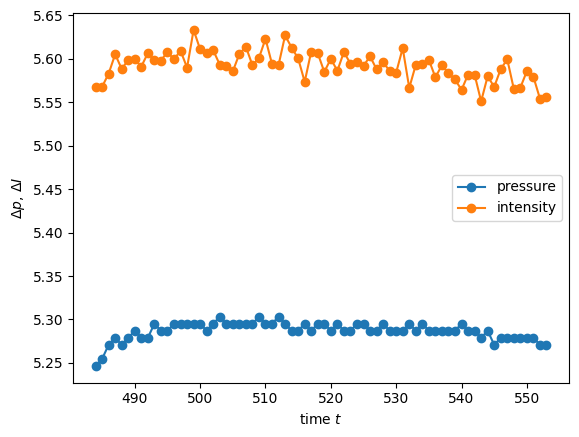

In [42]:
# 3
calibration.loc[484:553].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[484:553, 'window'] = 3

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

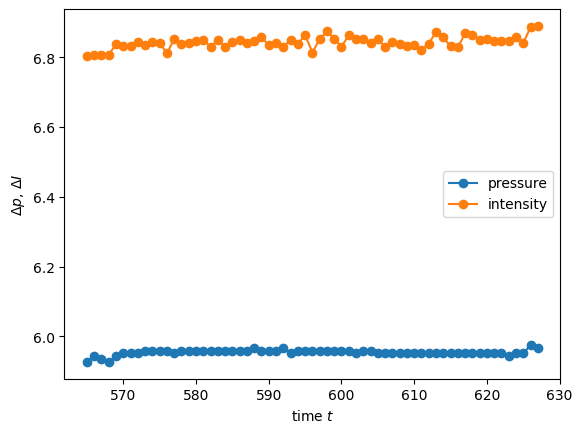

In [43]:
# 4
calibration.loc[565:627].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[565:627, 'window'] = 4

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

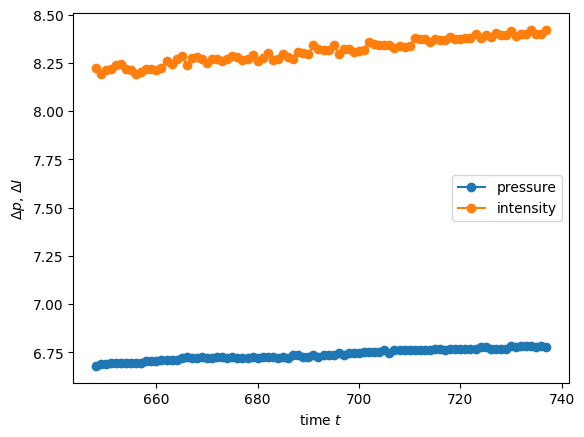

In [44]:
# 5 # 635:740
calibration.loc[648:737].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[648:737, 'window'] = 5

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

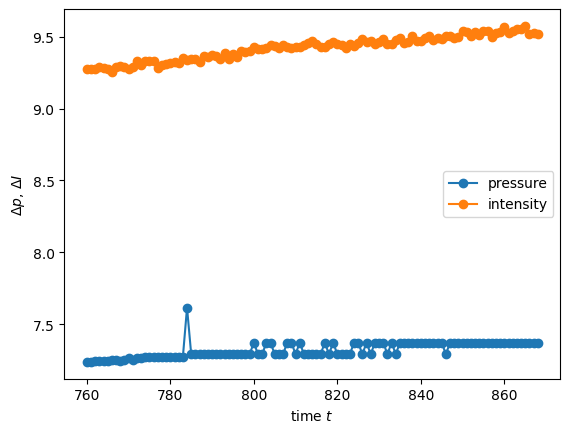

In [45]:
# 6 # 750: 868
calibration.loc[760:868].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[760:868, 'window'] = 6

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

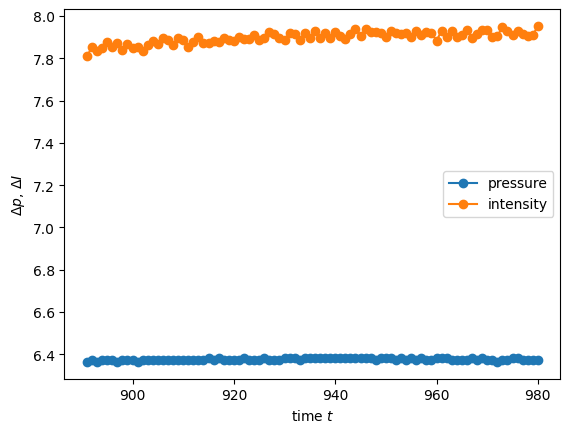

In [46]:
# 7
calibration.loc[891:980].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[891:980, 'window'] = 7

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

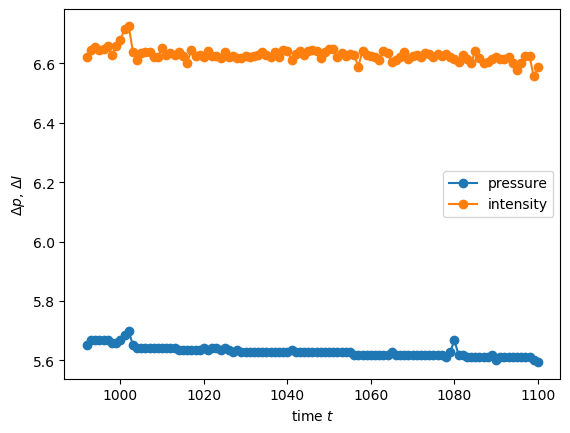

In [47]:
# 8
calibration.loc[992:1100].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[992:1100, 'window'] = 8

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

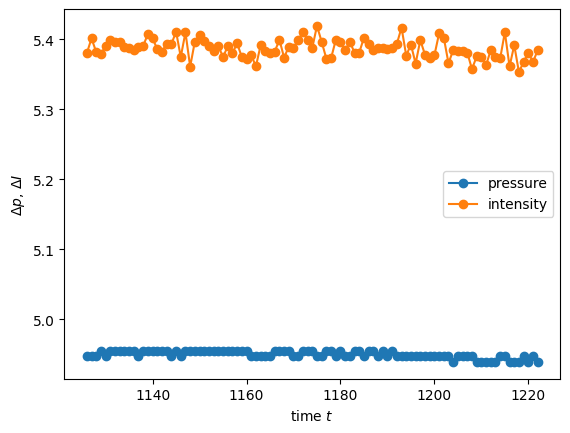

In [48]:
# 9
calibration.loc[1126:1222].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[1126:1222, 'window'] = 9

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

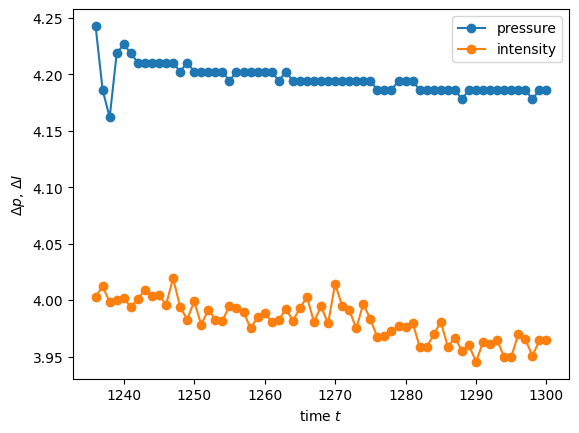

In [49]:
# 10
calibration.loc[1236:1300].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[1236:1300, 'window'] = 10

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

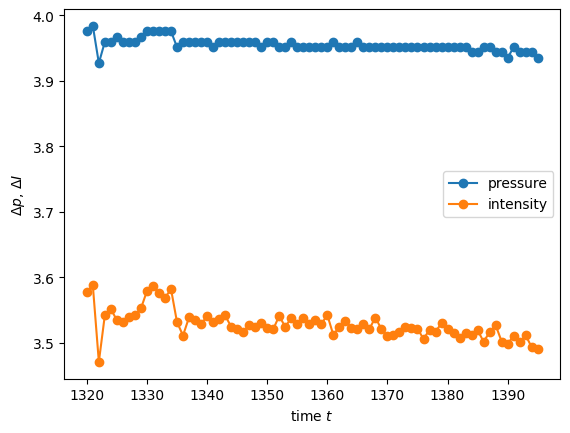

In [50]:
# 11
calibration.loc[1320:1395].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[1320:1395, 'window'] = 11

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

Text(0.5, 0, 'time $t$')

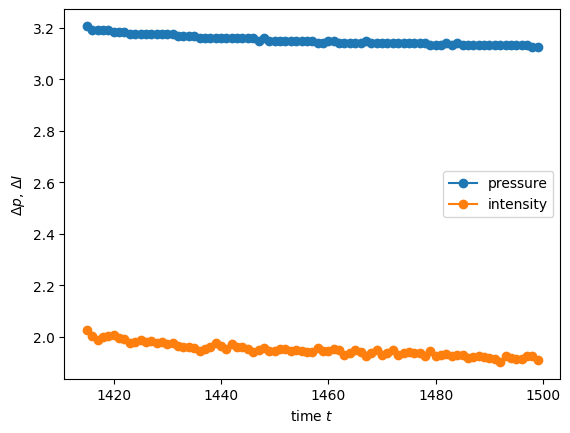

In [51]:
# 12
calibration.loc[1415:1499].plot(y=['pressure', 'intensity'], style='-o')
calibration.loc[1415:1499, 'window'] = 12

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

In [52]:
# # 13
# calibration.loc[1530:1600].plot(y=['pressure', 'intensity'], style='-o')
# calibration.loc[1530:1600, 'window'] = 13

## selected data

In [53]:
windows = calibration.dropna(subset='window')
selection = windows['window'] != 'leer'
measures = windows.groupby('window')
windows.head()

,time,pressure,intensity,time_2,intensity_2,window
58,44.25198,1.433478,0.008178,0 days 00:00:44.752020,0.006325,leer
59,45.25098,1.473956,0.007361,0 days 00:00:45.751980,0.007032,leer
60,46.25202,1.473956,0.006347,0 days 00:00:46.752000,0.007321,leer
61,47.25198,1.473956,0.007580,0 days 00:00:47.752020,0.006911,leer
62,48.25200,1.473956,0.006235,0 days 00:00:48.751980,0.007039,leer


In [54]:
probe = measures.get_group('probe')

probe_intensity = stats.linregress(x=probe.time, y=probe.intensity)
probe_pressure = stats.linregress(x=probe.time, y=probe.pressure)

Text(0.5, 0, 'time $t$')

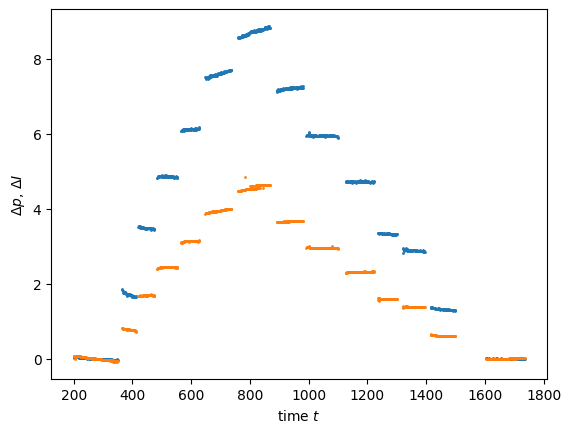

In [55]:
delta_I = windows['intensity'] - (windows['time'] * probe_intensity.slope + probe_intensity.intercept)
delta_p = windows['pressure'] - (windows['time'] * probe_pressure.slope + probe_pressure.intercept)
delta_I = delta_I[selection]
delta_p = delta_p[selection]

delta_I.plot(style='o', ms=1)
delta_p.plot(style='o', ms=1)


plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')


In [56]:
base = measures.get_group('leer')

base_intensity = stats.linregress(x=base.time, y=base.intensity)
base_pressure = stats.linregress(x=base.time, y=base.pressure)

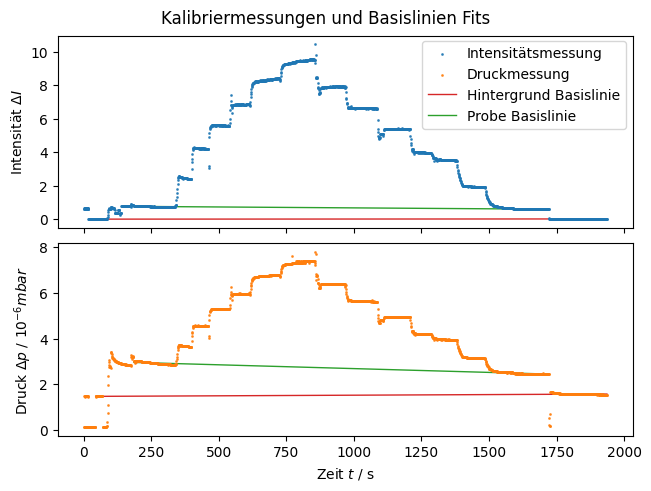

In [120]:
fig, axs = plt.subplots(nrows=2, sharex=True, constrained_layout=True)

# intensity

axs[0].scatter(data=calibration, x='time', y='intensity', s=1, label='Intensitätsmessung', alpha=0.8)
axs[0].plot(base['time'], 
            base_intensity.intercept + base_intensity.slope * base['time'], 
            color='tab:red',
            lw=1,
            zorder=0
           )
axs[0].plot(probe['time'], 
            probe_intensity.intercept + probe_intensity.slope * probe['time'], 
            color='tab:green',
            lw=1,
            zorder=0
           )
axs[0].set_ylabel('Intensität $\Delta I$')
# pressure

axs[1].scatter(data=calibration, x='time', y='pressure', s=1, color='tab:orange', label='Druckmessung', alpha=0.8)
axs[1].plot(base['time'], 
            base_pressure.intercept + base_pressure.slope * base['time'], 
            color='tab:red',
            label='Hintergrund Basislinie',
            lw=1,
            zorder=0
           )
axs[1].plot(probe['time'], 
            probe_pressure.intercept + probe_pressure.slope * probe['time'], 
            color='tab:green',
            label='Probe Basislinie',
            lw=1,
            zorder=0
           )
axs[1].set_ylabel('Druck $\Delta p$ / $10^{-6} mbar$')

axs[1].set_xlabel('Zeit $t$ / s')
fig.legend(loc='upper left', bbox_to_anchor=(0.64, 0.94))

fig.suptitle('Kalibriermessungen und Basislinien Fits')

fig.savefig(RESULTS/'kalibrierung_fits.png', dpi=500, bbox_inches='tight')

Text(0.5, 0, 'time $t$')

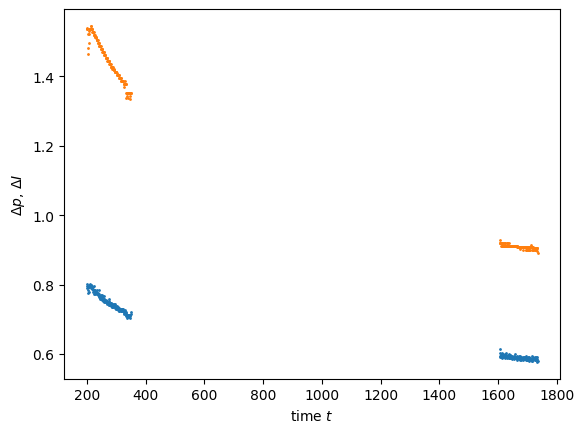

In [58]:
delta_I_probe = probe['intensity'] - (probe['time'] * base_intensity.slope + base_intensity.intercept)
delta_p_probe = probe['pressure'] - (probe['time'] * base_pressure.slope + base_pressure.intercept)

delta_I_probe.plot(style='o', ms=1)
delta_p_probe.plot(style='o', ms=1)

plt.ylabel('$\Delta p$, $\Delta I$')
plt.xlabel('time $t$')

In [59]:
delta_I_probe_split = delta_I_probe.loc[:500], delta_I_probe.loc[500:]
delta_p_probe_split = delta_p_probe.loc[:500], delta_p_probe.loc[500:]

In [60]:
import seaborn as sns

In [61]:
p1, p2 = delta_p_probe_split
p1 = p1.to_frame()
p2 = p2.to_frame()
p1['label'] = 'start'
p2['label'] = 'end'

comb_p = pd.concat([p1, p2])
p1['label'] = 'both'
p2['label'] = 'both'
comb_p = pd.concat([comb_p, pd.concat([p1, p2])])
comb_p = comb_p.rename({0: 'pressure'}, axis=1)
comb_p

,pressure,label
200,1.538253,start
201,1.538200,start
202,1.538147,start
203,1.521902,start
204,1.481370,start
...,...,...
1731,0.898369,both
1732,0.906412,both
1733,0.906359,both
1734,0.906306,both


<Axes: xlabel='label', ylabel='pressure'>

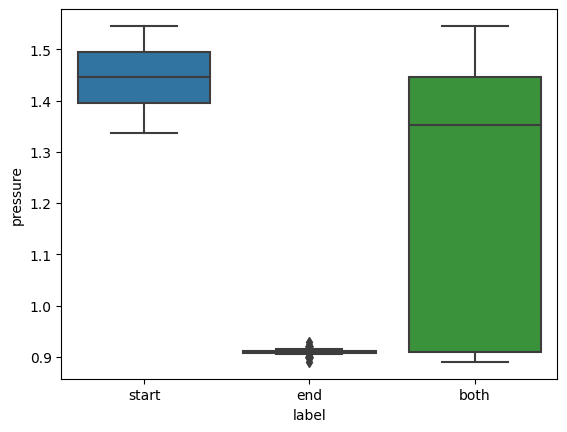

In [62]:
sns.boxplot(data=comb_p, y='pressure', x='label')

In [63]:
i1, i2 = delta_I_probe_split
i1 = i1.to_frame()
i2 = i2.to_frame()
i1['label'] = 'Start'
i2['label'] = 'Ende'

comb_i = pd.concat([i1, i2])
i1['label'] = 'Gesamt'
i2['label'] = 'Gesamt'
comb_i = pd.concat([comb_i, pd.concat([i1, i2])])
comb_i = comb_i.rename({0: 'intensity'}, axis=1)
comb_i

,intensity,label
200,0.802192,Start
201,0.794807,Start
202,0.789580,Start
203,0.792510,Start
204,0.784147,Start
...,...,...
1731,0.577316,Gesamt
1732,0.580166,Gesamt
1733,0.591379,Gesamt
1734,0.584533,Gesamt


<Axes: xlabel='label', ylabel='intensity'>

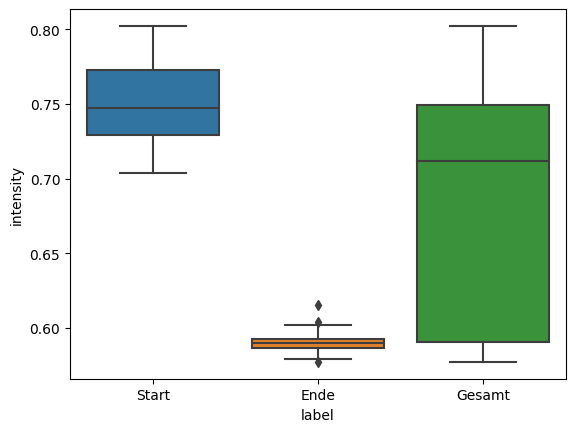

In [64]:
sns.boxplot(data=comb_i, y='intensity', x='label')

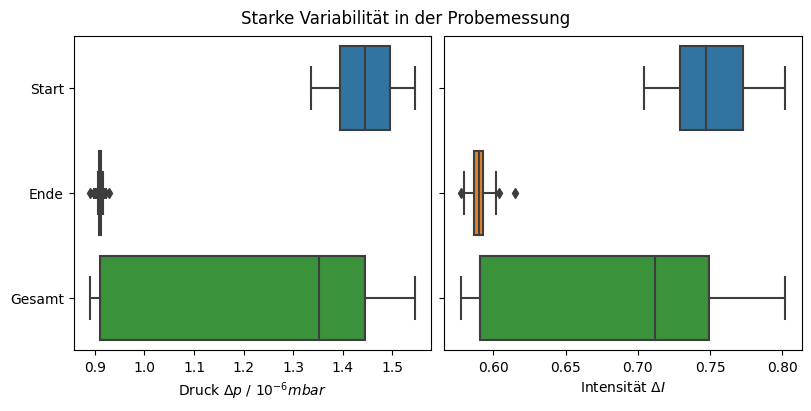

In [121]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 4), constrained_layout=True)

sns.boxplot(data=comb_p, x='pressure', y='label', ax=axs[0])
axs[0].set_xlabel('Druck $\Delta p$ / $10^{-6} mbar$')
sns.boxplot(data=comb_i, x='intensity', y='label', ax=axs[1])
axs[1].set_xlabel('Intensität $\Delta I$')
for ax in axs:
    ax.set_ylabel('')
fig.suptitle('Starke Variabilität in der Probemessung')
fig.savefig(RESULTS/'probemessung_variabilität.png', dpi=500, bbox_inches='tight')

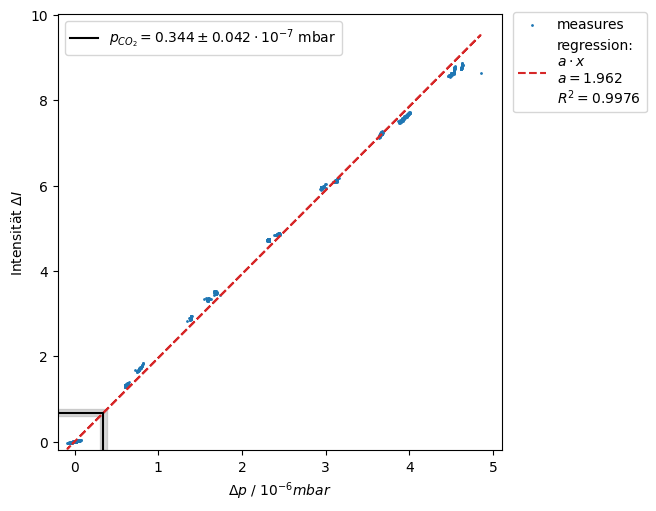

In [124]:
a, cov = optimize.curve_fit(no_intercept, xdata=delta_p, ydata=delta_I, )
a = a[0]
# perr = np.sqrt(np.diag(cov))

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

zero_point = -0.2
foreground_color = 'black'
background_color = 'tab:grey'


reg = ax.plot(delta_p, 
        no_intercept(a, delta_p), 
        color='tab:red', linestyle='dashed',
       )

mess = ax.scatter(x=delta_p, y=delta_I, s=1)


y_probe = delta_I_probe.mean()
y_std = delta_I_probe.std()
y_range = [y_probe - delta_I_probe.std(), y_probe + delta_I_probe.std()]

x_probe = delta_I_probe.mean() / a
x_std = delta_I_probe.std() / a
x_range = [y/a for y in y_range]


ax.plot([zero_point, x_probe, x_probe], 
        [y_probe, y_probe, zero_point], 
        color=foreground_color,
        label='$p_{CO_2} = ' + f'{x_probe:.3f}\pm{x_std:.3f}' + ' \cdot 10^{-7}$ mbar'
       )
ax.fill([zero_point, x_range[1], 
         x_range[1], x_range[0], 
         x_range[0], zero_point], 
        [y_range[1], y_range[1], 
         zero_point, zero_point,
         y_range[0], y_range[0]], 
        color=background_color,
        alpha=0.3,
       )
ax.legend()
ax.set_xlabel('$\Delta p$ / $10^{-6} mbar$')
ax.set_ylabel('Intensität $\Delta I$')

ax.set_xlim(left=zero_point)
ax.set_ylim(bottom=zero_point)

r2 = r_squared(no_intercept, a, x_data=delta_p, y_data=delta_I)
regression_text = f'a \cdot x$\n$a={a:.3f}$\n$R^2 = {r2:.4f}'
fig.legend(handles=[mess, reg[0]], labels=['measures', f'regression:\n${regression_text}$'], bbox_to_anchor=(1, 1), loc='upper left')

fig.savefig(RESULTS/'kalibrier_probe.png', dpi=500, bbox_inches='tight')

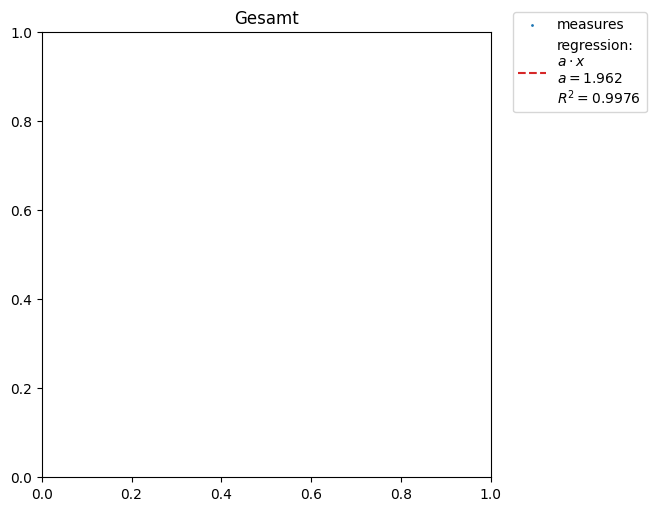

In [123]:
a, cov = optimize.curve_fit(no_intercept, xdata=delta_p, ydata=delta_I, )
a = a[0]
# perr = np.sqrt(np.diag(cov))

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

zero_point = -0.2
foreground_color = 'black'
background_color = 'tab:grey'

ax.set_title('Gesamt')

for ax, _probe in zip(axs, [delta_I_probe, *delta_I_probe_split]):
    reg = ax.plot(delta_p, 
            no_intercept(a, delta_p), 
            color='tab:red', linestyle='dashed',
           )

    mess = ax.scatter(x=delta_p, y=delta_I, s=1)

    
    y_probe = _probe.mean()
    y_std = _probe.std()
    y_range = [y_probe - _probe.std(), y_probe + _probe.std()]
    
    x_probe = _probe.mean() / a
    x_std = _probe.std() / a
    x_range = [y/a for y in y_range]


    ax.plot([zero_point, x_probe, x_probe], 
            [y_probe, y_probe, zero_point], 
            color=foreground_color,
            label=f'${x_probe:.3f}\pm{x_std:.3f}' + ' \cdot 10^{-7}$ mbar'
           )
    ax.fill([zero_point, x_range[1], 
             x_range[1], x_range[0], 
             x_range[0], zero_point], 
            [y_range[1], y_range[1], 
             zero_point, zero_point,
             y_range[0], y_range[0]], 
            color=background_color,
            alpha=0.3,
           )
    ax.legend()
    ax.set_xlabel('$\Delta p$ / $10^{-6} mbar$')
axs[0].set_ylabel('Intensität $\Delta I$')

    

ax.set_xlim(left=zero_point)
ax.set_ylim(bottom=zero_point)

r2 = r_squared(no_intercept, a, x_data=delta_p, y_data=delta_I)
regression_text = f'a \cdot x$\n$a={a:.3f}$\n$R^2 = {r2:.4f}'
fig.legend(handles=[mess, reg[0]], labels=['measures', f'regression:\n${regression_text}$'], bbox_to_anchor=(1, 1), loc='upper left')





fig.savefig(RESULTS/'kalibrier_probe.png', dpi=500, bbox_inches='tight')

## composition

\begin{align}
    P_{ges} &= \sum_i p_i \\
    p_{ges, anzeig} &= \sum_i p_i \cdot IW_i \\
            &= p_{CO2} \cdot IW_{CO2} + p_{Ar} \cdot IW_{Ar} \\
    p_{Ar} &= \frac{p_{ges, anzeig} - p_{CO2} \cdot IW_{CO2}}{IW_{Ar}}
\end{align}

In [112]:
for p_probe, i_probe, name in zip([delta_p_probe, *delta_p_probe_split], 
                                  [delta_I_probe, *delta_I_probe_split],
                                  'full start end'.split(),
                                 ):
    p_ges_anzeig = p_probe.mean() * IW_CO2
    p_co2 = i_probe.mean() / a

    p_ar = (p_ges_anzeig - p_co2 * IW_CO2) / IW_AR
    
    p_ges = p_ar + p_co2
    percentage_co2 = p_co2 / p_ges
    percentage_ar = p_ar / p_ges
    with open(f'{name}.dat', 'w') as f:
        f.write(f'{name.title()} probe contains {percentage_co2:#.2%} CO2 and {percentage_ar:#.2%} Ar.\n')
        f.write(f'{p_co2*1e-6 = :#.4g} mbar\n')
        f.write(f'{p_ar*1e-6 = :#.4g} mbar\n')

wild dass man keine fehler rechnung machen muss....